In [2]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch
import keras
import os
import cv2
import pickle

from keras.activations import get
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
MODEL_PATH = "captcha_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)


In [4]:
try:
    # Try to load existing encoder
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    print("Loaded existing label encoder")
except FileNotFoundError:
    # Create and fit a new encoder
    print("Creating new label encoder")
    label_encoder = LabelEncoder()
    
    # Get all unique labels from your dataset
    samples_dir = "samples"
    labels = []
    for file in os.listdir(samples_dir):
        if file.endswith((".png", ".jpg")):
            # Extract label from filename (assuming filename is the label)
            label = file.split('.')[0]
            labels.append(label)
    
    # Fit the encoder
    label_encoder.fit(labels)
    
    # Save the encoder for future use
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    print("Label encoder saved")

Loaded existing label encoder


In [5]:
nb_classes = len(label_encoder.classes_)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [6]:
classifier = TensorFlowV2Classifier(
    clip_values=(0, 1),
    model=model,
    nb_classes=nb_classes,
    input_shape=(50, 200, 1),
    loss_object=loss_object,
)

In [7]:
def load_images(folder="samples", max_images=20):
    image_files = [f for f in os.listdir(folder) if f.endswith((".png", ".jpg"))]
    if not image_files:
        print("No images found in samples folder")
        return None, None
    
    # Limit the number of images to process
    image_files = image_files[:max_images]
    
    images = []
    labels = []
    
    for file in image_files:
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (200, 50))
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)  # Shape: (50, 200, 1)
        
        true_label = file.split('.')[0]
        label_idx = label_encoder.transform([true_label])[0]
        
        images.append(img)
        labels.append(label_idx)
    
    return np.array(images), np.array(labels)

In [8]:
test_images, test_labels = load_images()


In [9]:
clean_preds = model.predict(test_images)
clean_accuracy = np.mean(np.argmax(clean_preds, axis=1) == test_labels)
print(f"Clean accuracy: {clean_accuracy:.4f}")

1/1 [==============================] - 0s 240ms/step
Clean accuracy: 1.0000


In [10]:
eps_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
results = []

1/1 [==============================] - 0s 37ms/step
Epsilon: 0.01, Adversarial Accuracy: 1.0000
1/1 [==============================] - 0s 34ms/step
Epsilon: 0.05, Adversarial Accuracy: 0.5000
1/1 [==============================] - 0s 41ms/step
Epsilon: 0.1, Adversarial Accuracy: 0.1000
1/1 [==============================] - 0s 37ms/step
Epsilon: 0.15, Adversarial Accuracy: 0.0000
1/1 [==============================] - 0s 38ms/step
Epsilon: 0.2, Adversarial Accuracy: 0.0000
1/1 [==============================] - 0s 33ms/step
Epsilon: 0.25, Adversarial Accuracy: 0.0000


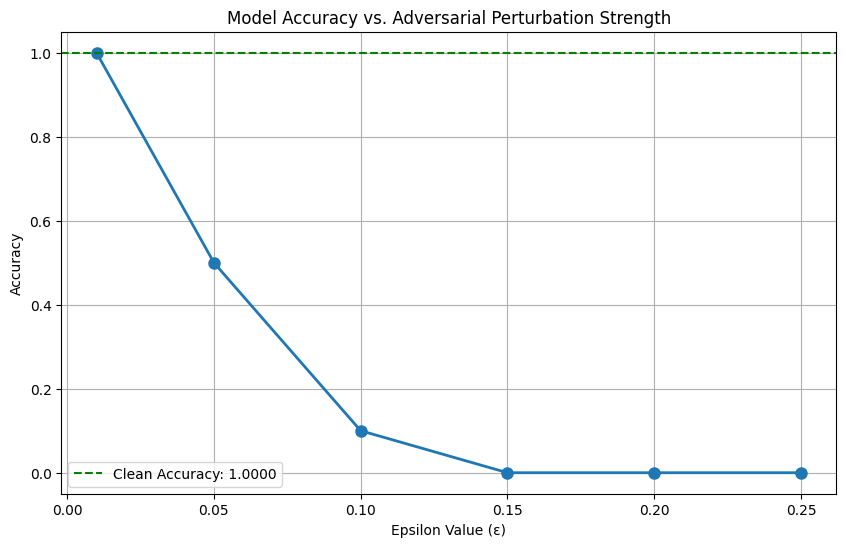

In [11]:
for eps in eps_values:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    test_images_adv = attack_fgsm.generate(x=test_images)
    
    # Evaluate on adversarial examples
    adv_preds = model.predict(test_images_adv)
    adv_accuracy = np.mean(np.argmax(adv_preds, axis=1) == test_labels)
    
    results.append((eps, adv_accuracy))
    print(f"Epsilon: {eps}, Adversarial Accuracy: {adv_accuracy:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
eps_values = [r[0] for r in results]
acc_values = [r[1] for r in results]

plt.plot(eps_values, acc_values, 'o-', linewidth=2, markersize=8)
plt.axhline(y=clean_accuracy, color='g', linestyle='--', label=f'Clean Accuracy: {clean_accuracy:.4f}')
plt.xlabel('Epsilon Value (ε)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Adversarial Perturbation Strength')
plt.grid(True)
plt.legend()
plt.show()


1/1 [==============================] - 0s 16ms/step


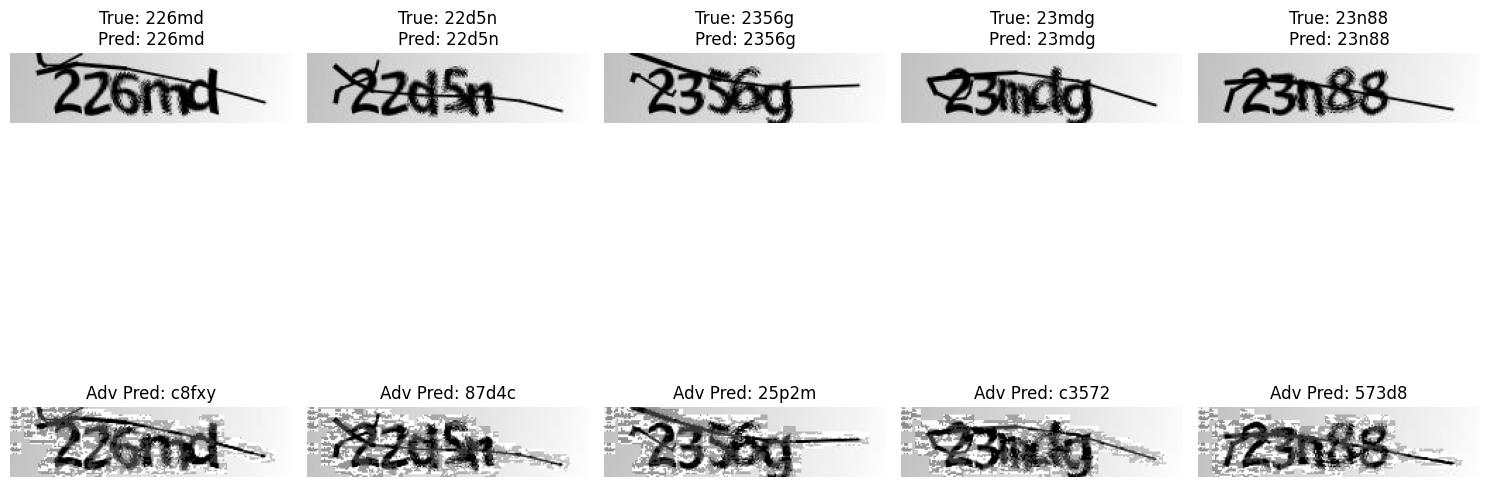

In [12]:
plt.figure(figsize=(15, 10))
n_examples = min(5, len(test_images))

# Use epsilon = 0.2 for visualization
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2)
test_images_adv = attack_fgsm.generate(x=test_images[:n_examples])

for i in range(n_examples):
    # Original image
    plt.subplot(2, n_examples, i+1)
    plt.imshow(np.squeeze(test_images[i]), cmap='gray')
    true_label = label_encoder.inverse_transform([test_labels[i]])[0]
    pred = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0)))
    pred_label = label_encoder.inverse_transform([pred])[0]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(2, n_examples, i+1+n_examples)
    plt.imshow(np.squeeze(test_images_adv[i]), cmap='gray')
    adv_pred = np.argmax(model.predict(np.expand_dims(test_images_adv[i], axis=0)))
    adv_pred_label = label_encoder.inverse_transform([adv_pred])[0]
    plt.title(f"Adv Pred: {adv_pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
sample_idx = 0  # Choose one sample to visualize
sample_image = test_images[sample_idx]
true_label = label_encoder.inverse_transform([test_labels[sample_idx]])[0]


1/1 [==============================] - 0s 17ms/step


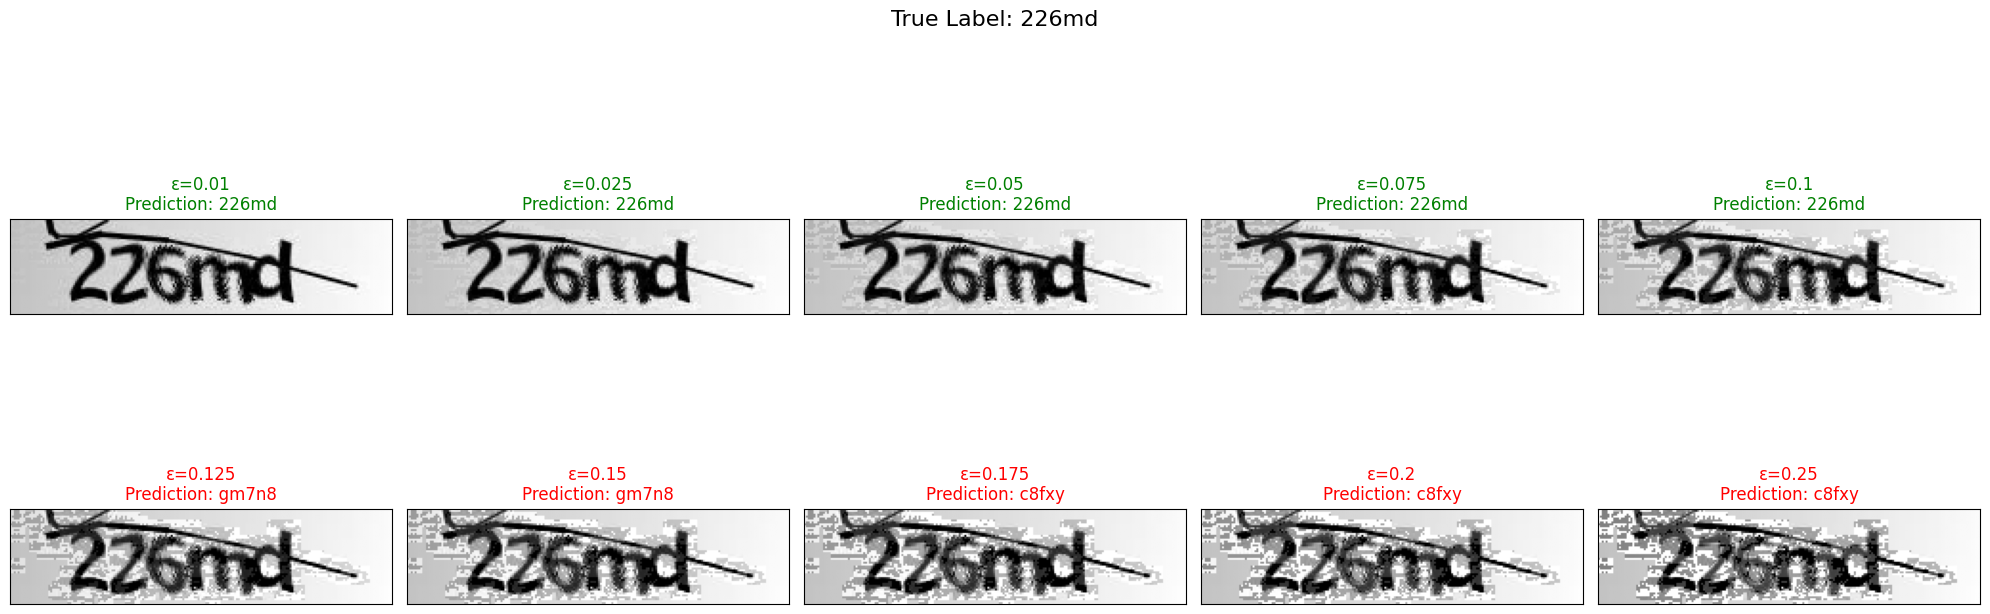

In [14]:
nrows, ncols = 2, 5
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
counter = 0
for i in range(nrows):
    for j in range(ncols):
        attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps_to_try[counter])
        adv_image = attack_fgsm.generate(x=np.expand_dims(sample_image, axis=0))
        
        axes[i, j].imshow(np.squeeze(adv_image), cmap='gray')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        # Make prediction
        prediction = model.predict(adv_image)
        pred_idx = np.argmax(prediction)
        pred_label = label_encoder.inverse_transform([pred_idx])[0]
        
        # Check if prediction matches true label
        is_correct = pred_label == true_label
        color = "green" if is_correct else "red"
        
        axes[i, j].set_title(
            f"ε={eps_to_try[counter]}\nPrediction: {pred_label}",
            color=color
        )
        
        counter += 1

plt.suptitle(f"True Label: {true_label}", fontsize=16)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 34ms/step


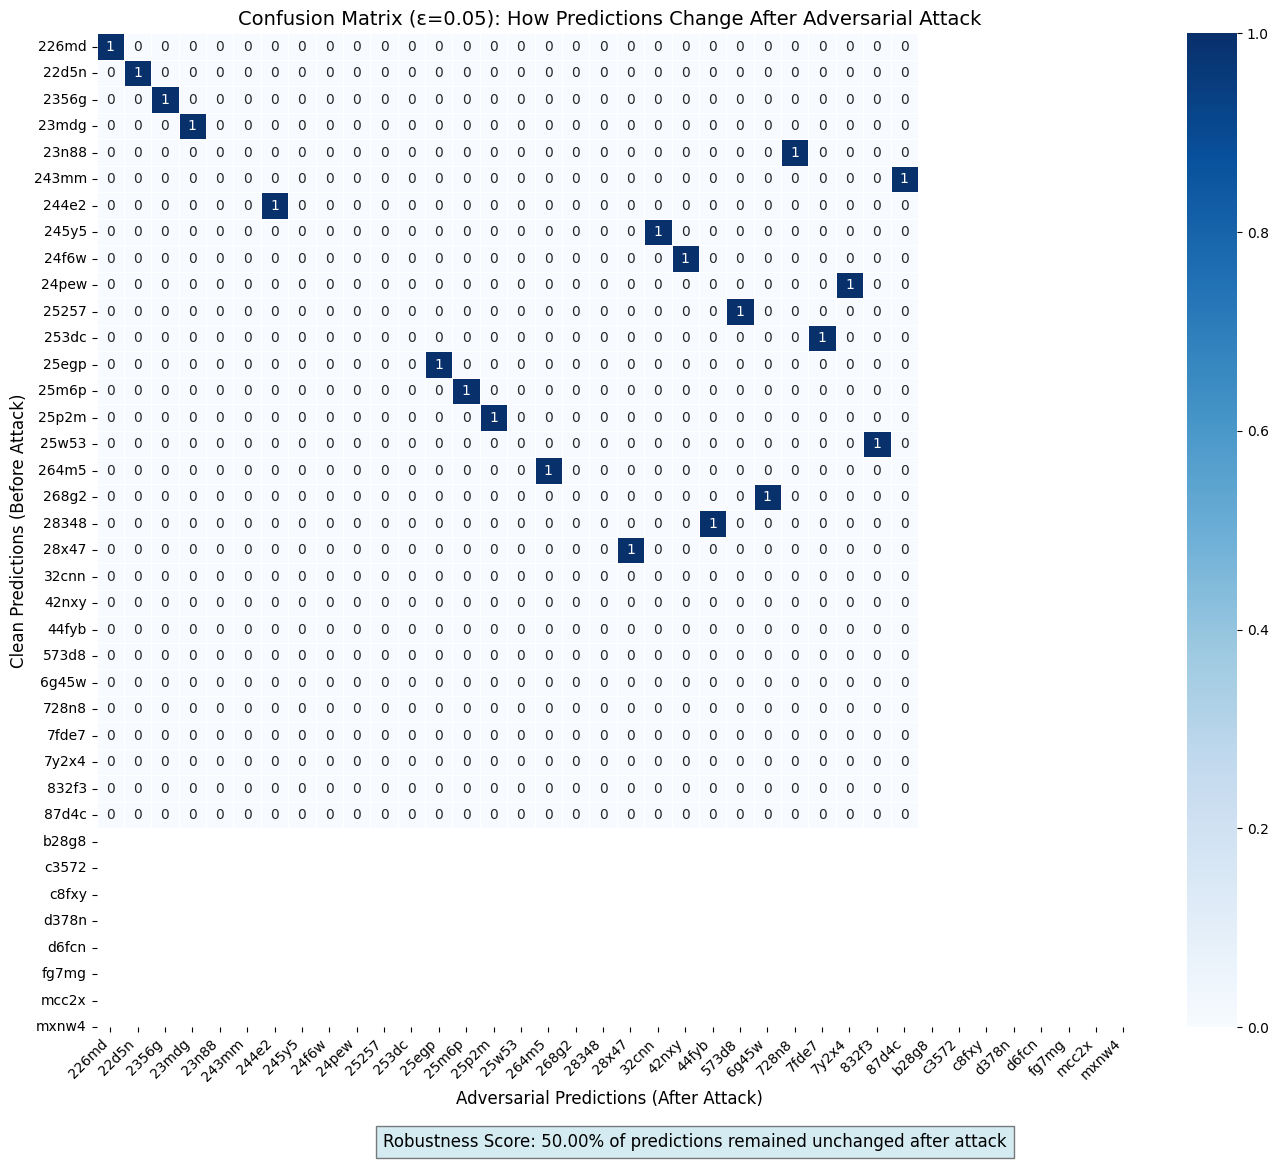

1/1 [==============================] - 0s 32ms/step


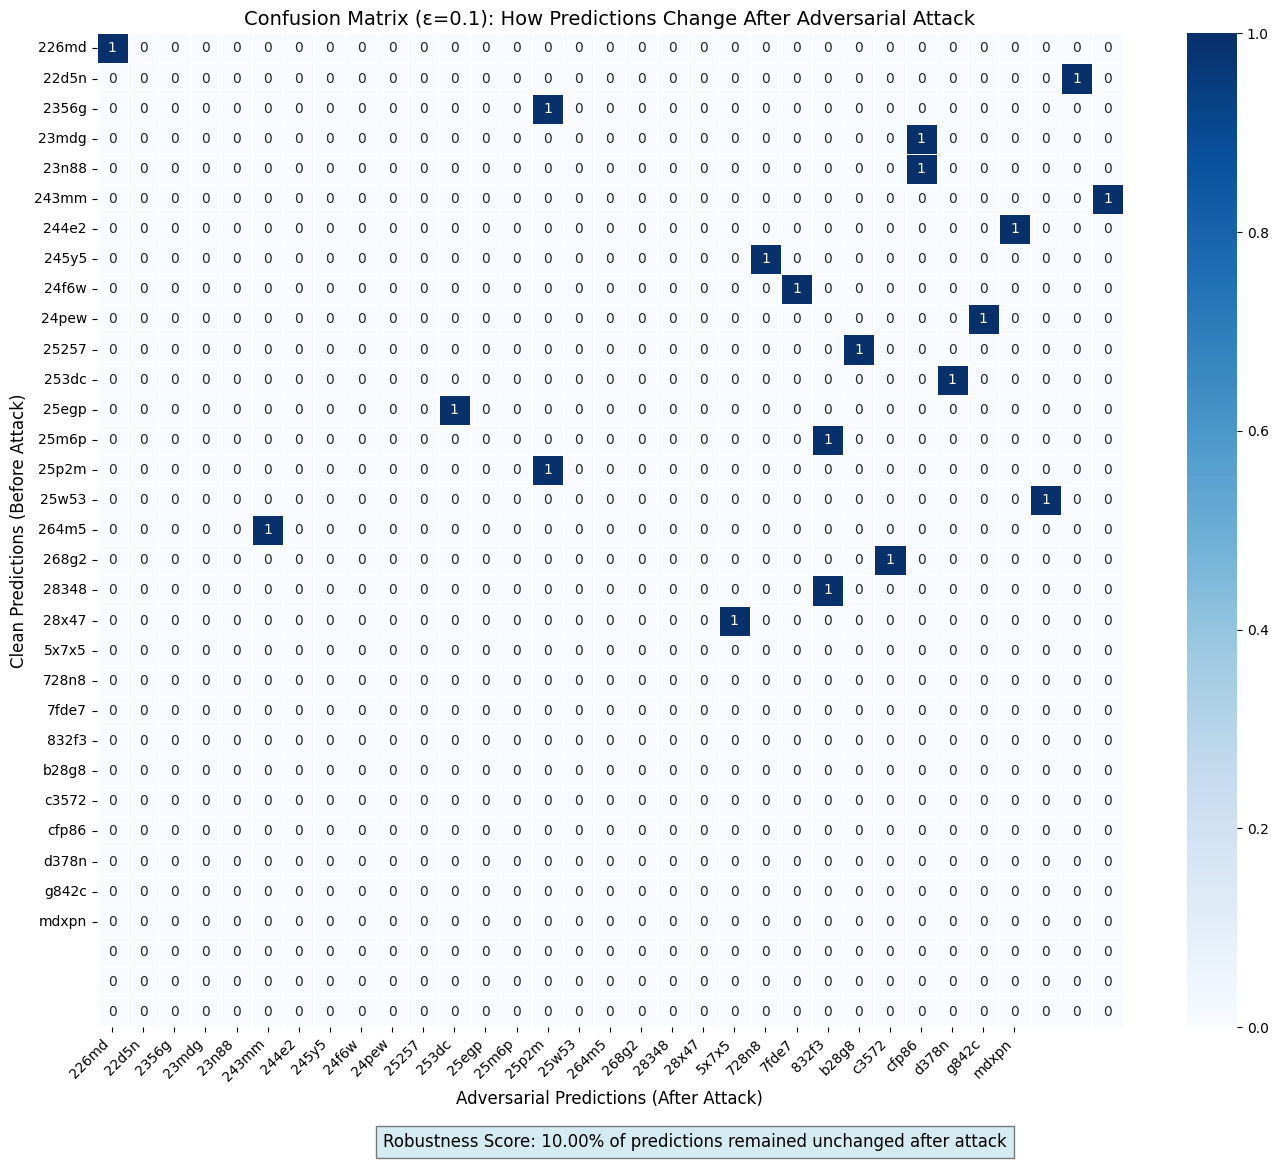

1/1 [==============================] - 0s 31ms/step


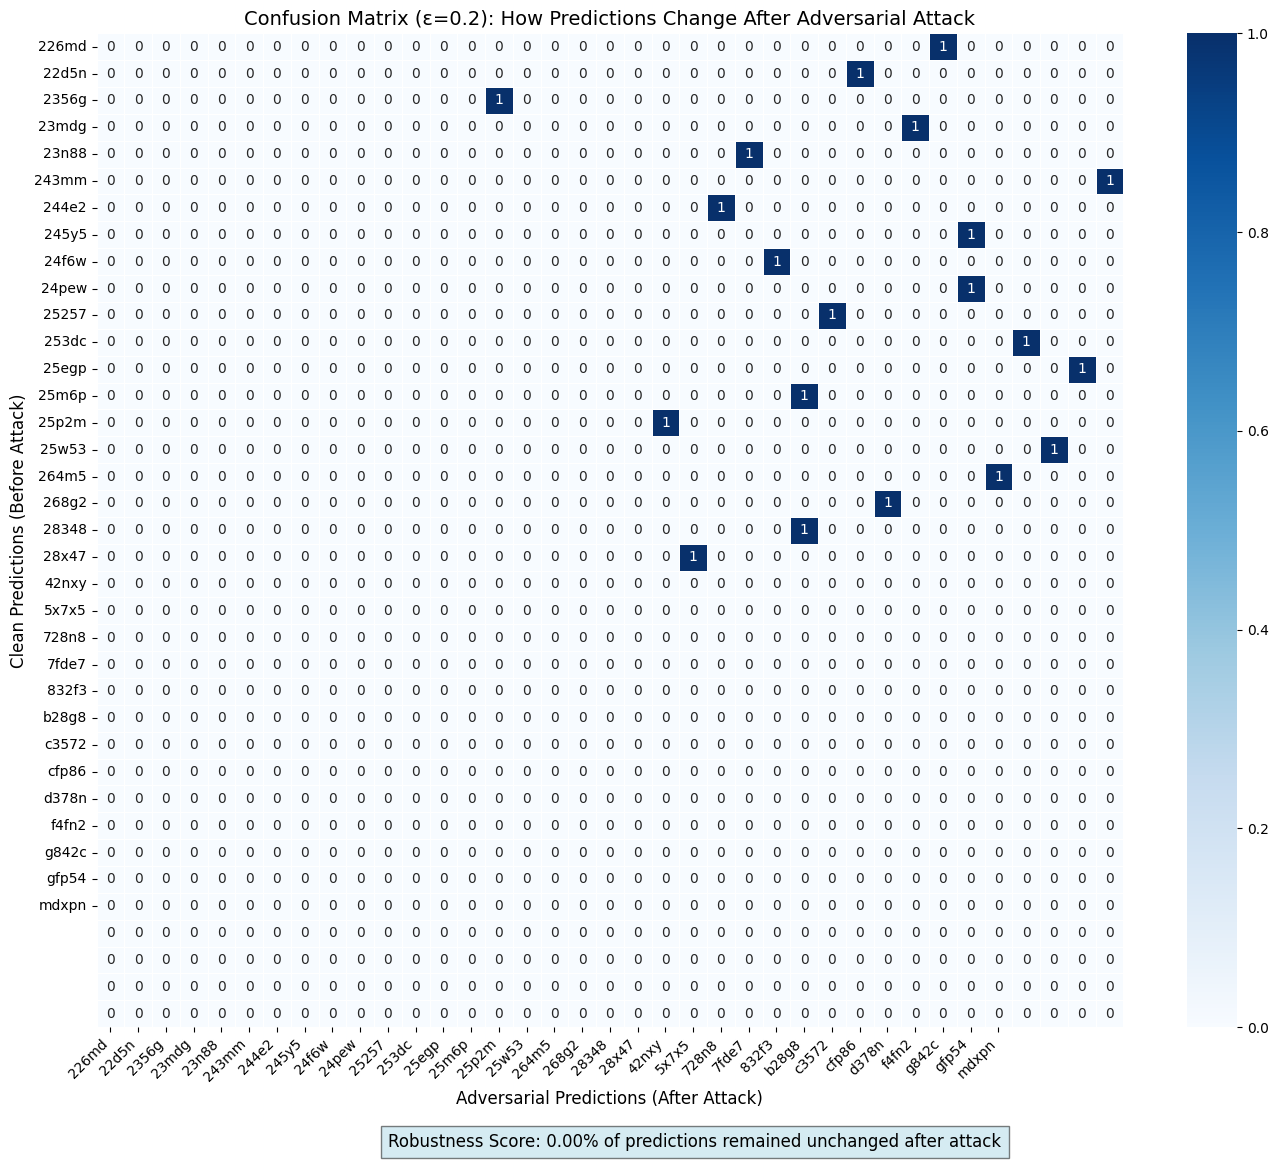

1/1 [==============================] - 0s 33ms/step


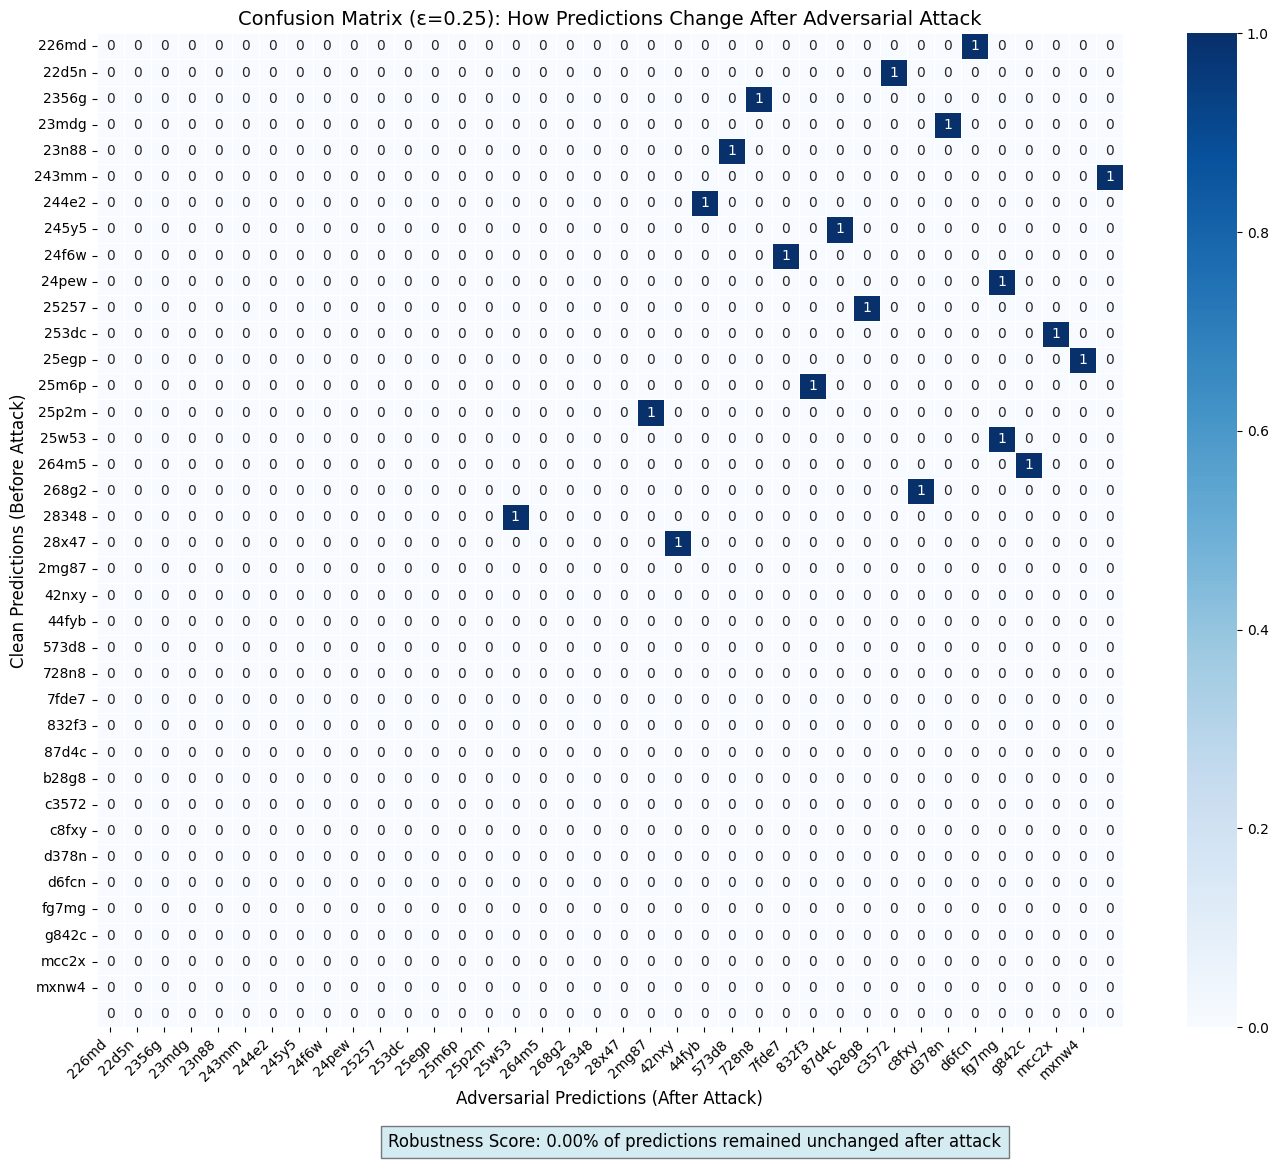

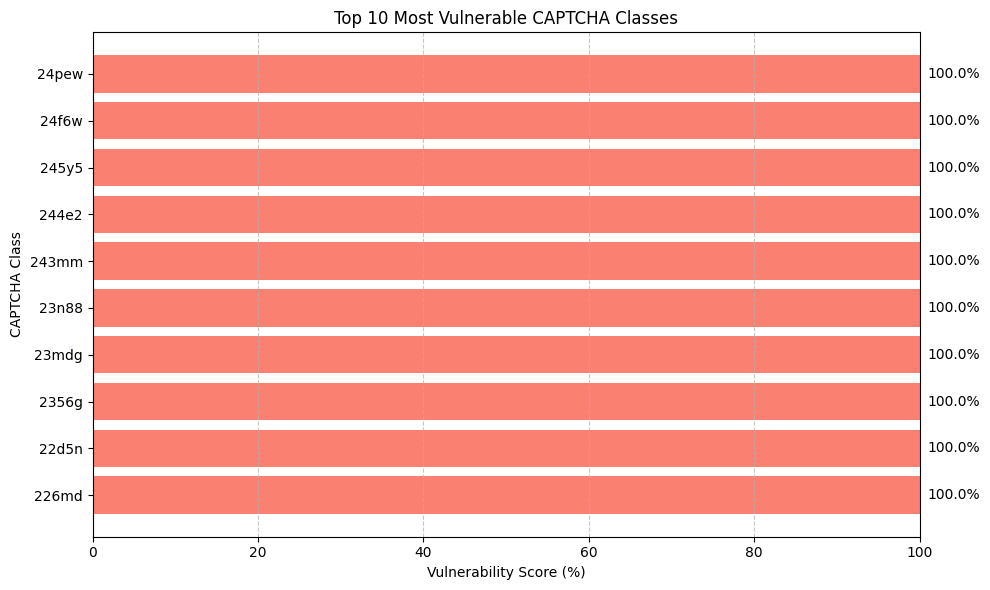

1/1 [==============================] - 0s 16ms/step


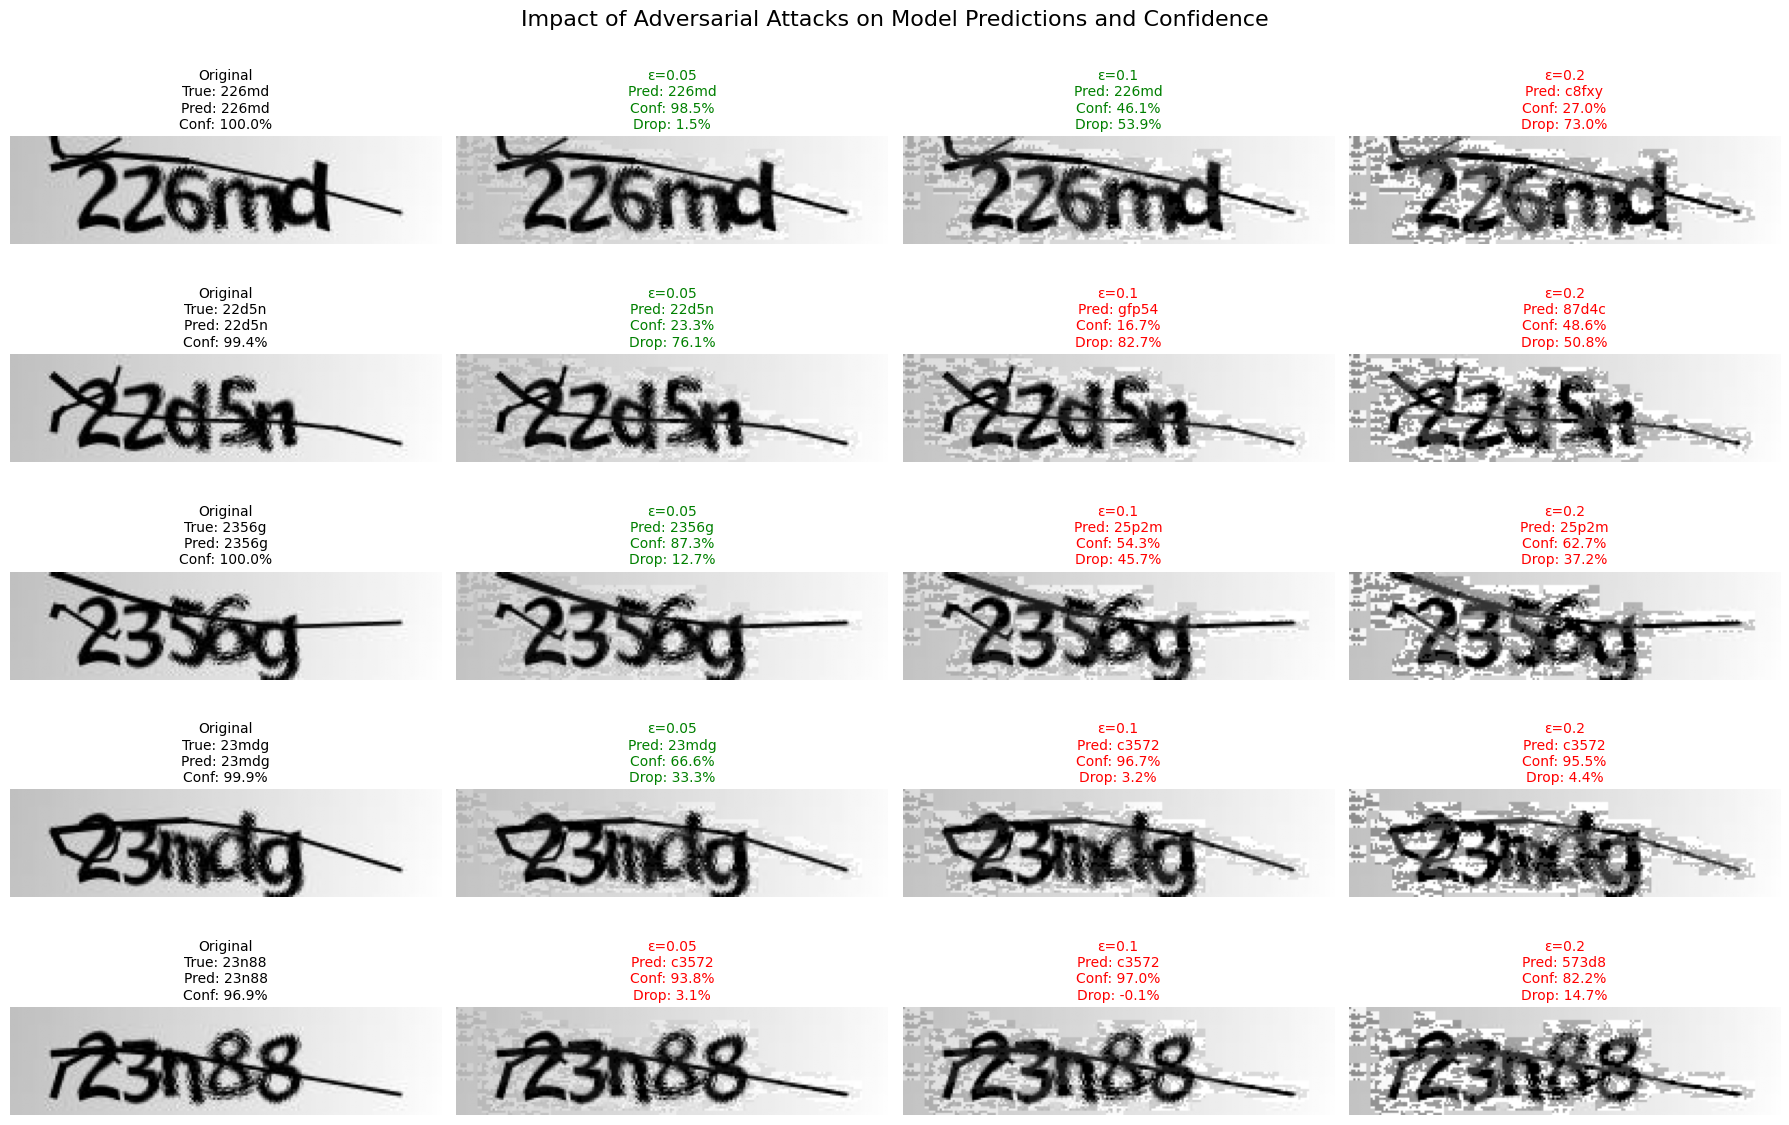

In [15]:
# Import required libraries for confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create separate confusion matrices for multiple epsilon values
epsilon_values = [0.05, 0.1, 0.2, 0.25]  # Different epsilon values to analyze

# Find the maximum value across all confusion matrices to use a consistent color scale
max_value = 0
all_cms = []

for epsilon in epsilon_values:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=epsilon)
    test_images_adv = attack_fgsm.generate(x=test_images)
    
    clean_preds = np.argmax(model.predict(test_images), axis=1)
    adv_preds = np.argmax(model.predict(test_images_adv), axis=1)
    
    cm = confusion_matrix(clean_preds, adv_preds)
    all_cms.append(cm)
    max_value = max(max_value, np.max(cm))

# Create a separate figure for each confusion matrix
for idx, epsilon in enumerate(epsilon_values):
    plt.figure(figsize=(14, 12))
    
    cm = all_cms[idx]
    
    # Get unique class labels for better visualization
    unique_labels = sorted(set(np.argmax(model.predict(test_images), axis=1)) | 
                          set(np.argmax(model.predict(attack_fgsm.generate(x=test_images)), axis=1)))
    class_names = [label_encoder.inverse_transform([i])[0] for i in unique_labels]
    
    # Create a more informative heatmap with consistent color scaling
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                linewidths=0.5, vmin=0, vmax=max_value)
    
    # Rotate the tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add descriptive labels
    plt.xlabel('Adversarial Predictions (After Attack)', fontsize=12)
    plt.ylabel('Clean Predictions (Before Attack)', fontsize=12)
    plt.title(f'Confusion Matrix (ε={epsilon}): How Predictions Change After Adversarial Attack', fontsize=14)
    
    # Calculate robustness score
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=epsilon)
    clean_preds = np.argmax(model.predict(test_images), axis=1)
    adv_preds = np.argmax(model.predict(attack_fgsm.generate(x=test_images)), axis=1)
    correct_predictions = np.sum(clean_preds == adv_preds)
    total_predictions = len(clean_preds)
    robustness_score = correct_predictions / total_predictions * 100
    
    # Add robustness score to the plot
    plt.figtext(0.5, 0.01, 
               f"Robustness Score: {robustness_score:.2f}% of predictions remained unchanged after attack",
               ha="center", fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.5, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Add analysis of most vulnerable classes
class_vulnerability = {}
for i in range(len(all_cms[3])):  # Using the highest epsilon confusion matrix
    if i < len(class_names):
        # Calculate how often this class changes prediction
        total = all_cms[3][i].sum()
        unchanged = all_cms[3][i, i] if i < all_cms[3].shape[1] else 0
        changed_ratio = 1.0 - (unchanged / total) if total > 0 else 0
        class_vulnerability[class_names[i]] = changed_ratio * 100

# Sort classes by vulnerability
sorted_vulnerability = sorted(class_vulnerability.items(), key=lambda x: x[1], reverse=True)

# Display the most vulnerable classes
plt.figure(figsize=(10, 6))
classes = [x[0] for x in sorted_vulnerability[:10]]  # Top 10 most vulnerable
vulnerability_scores = [x[1] for x in sorted_vulnerability[:10]]

plt.barh(classes, vulnerability_scores, color='salmon')
plt.xlabel('Vulnerability Score (%)')
plt.ylabel('CAPTCHA Class')
plt.title('Top 10 Most Vulnerable CAPTCHA Classes')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels
for i, v in enumerate(vulnerability_scores):
    plt.text(v + 1, i, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.show()

# Visualize some examples with prediction percentages
plt.figure(figsize=(18, 12))
n_examples = min(5, len(test_images))

# Select a few epsilon values to compare
eps_to_compare = [0.05, 0.1, 0.2]
n_eps = len(eps_to_compare)

# For each test image
for i in range(n_examples):
    # Original image (first column)
    plt.subplot(n_examples, n_eps + 1, i * (n_eps + 1) + 1)
    plt.imshow(np.squeeze(test_images[i]), cmap='gray')
    
    # Get true label and clean prediction
    true_label = label_encoder.inverse_transform([test_labels[i]])[0]
    clean_pred = model.predict(np.expand_dims(test_images[i], axis=0))
    pred_idx = np.argmax(clean_pred)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = clean_pred[0][pred_idx] * 100
    
    plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", fontsize=10)
    plt.axis('off')
    
    # For each epsilon value
    for j, eps in enumerate(eps_to_compare):
        # Create adversarial example
        attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
        adv_image = attack_fgsm.generate(x=np.expand_dims(test_images[i], axis=0))
        
        # Display adversarial image
        plt.subplot(n_examples, n_eps + 1, i * (n_eps + 1) + j + 2)
        plt.imshow(np.squeeze(adv_image), cmap='gray')
        
        # Get prediction and confidence
        adv_pred = model.predict(adv_image)
        adv_pred_idx = np.argmax(adv_pred)
        adv_pred_label = label_encoder.inverse_transform([adv_pred_idx])[0]
        adv_confidence = adv_pred[0][adv_pred_idx] * 100
        
        # Calculate confidence drop
        conf_drop = confidence - adv_confidence
        
        # Set title color based on whether prediction changed
        title_color = 'red' if adv_pred_label != pred_label else 'green'
        
        plt.title(f"ε={eps}\nPred: {adv_pred_label}\nConf: {adv_confidence:.1f}%\nDrop: {conf_drop:.1f}%", 
                 color=title_color, fontsize=10)
        plt.axis('off')

plt.suptitle("Impact of Adversarial Attacks on Model Predictions and Confidence", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()